In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
import tensorflow as tf

from sklearn.model_selection import train_test_split
from skimage import color, exposure, filters, io, morphology, util
from math import sqrt
from numpy import loadtxt
from tensorflow import keras
from keras import backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Sequential, load_model
from keras.layers import Conv2D, Dense, Dropout, Flatten, MaxPooling2D, Reshape
from keras.optimizers import SGD

### TRANSFER LEARNING

#### 1.
Bangun sebuah model $\text{Convolutional Neural Network}$ dengan arsitektur dasar sebagai berikut :
- Convolutional Layer ($25$ maps, kernel $3 \times 3$)
- Pooling Layer ($2 \times 2$)
- Activation Function ($\text{ReLU function}$)
- Convolutional Layer ($50$ maps, kernel $3 \times 3$)
- Pooling Layer ($2 \times 2$)
- Activation Function ($\text{ReLU function}$)
- Convolutional Layer ($100$ maps, kernel $3 \times 3$)
- Pooling Layer ($2 \times 2$)
- Activation Function ($\text{ReLU function}$)
- Hidden Layer ($100$ neuron)
- Activation Function ($\text{ReLU function}$)
- Output Layer ($10$ kelas)
- Activation Function ($\text{Softmax function}$)
- Classification Result

Dengan tambahan beberapa seperti:
- Adam optimization
- Early Stop

##### Mendefinisikan Fungsi Bantuan
Untuk memudahkan implementasi, berikut beberapa fungsi bantuan yang akan dipakai

###### Menghitung $\text{recall}$ atau $\text{sensitivity}$
$$\text{recall} = \frac{t_p}{t_p+t_n}$$

In [2]:
def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())

###### Menghitung $\text{precision}$
$$\text{precision} = \frac{t_p}{t_p + f_p}$$

In [3]:
def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    return true_positives / (predicted_positives + K.epsilon())

###### Menghitung $\text{specificity}$
$$\text{specificity} = \frac{t_n}{t_n + f_p}$$

In [4]:
def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1 - y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

###### Menghitung $f_{1}\text{ Score}$
Kita tau bahwa
$$f_{\beta} = (1 + \beta^{2}) \cdot \frac{\text{precision} \cdot \text{recall}}{(\beta^{2} \cdot \text{precision}) + \text{recall}}$$
Sehingga 
$$f_{1} = (1 + 1^{2}) \cdot \frac{\text{precision} \cdot \text{recall}}{(1^{2} \cdot \text{precision}) + \text{recall}}$$
$$f_{1} = (2) \cdot \frac{\text{precision} \cdot \text{recall}}{(\text{precision}) + \text{recall}}$$



In [5]:
def f1_score(y_true, y_pred):
    precision_val = precision(y_true, y_pred)
    recall_val = recall(y_true, y_pred)
    return 2*((precision_val * recall_val)/(precision_val + recall_val + K.epsilon()))

**n.b.: Semua fungsi pada bagian penyebut ditambah epsilon untuk menghindari dibagi $0$ dikarenakan memasukkan input sebanyak $0$**

###### Fungsi Bantuan untuk Melakukan Prediksi dan Menampilkan Metric

In [6]:
def predict_and_get_metrics(model, x_test, y_test, label):
    _, accuracy, sensitivity, specificity, score_f1 = model.evaluate(x_test, y_test, verbose=0)
    return pd.DataFrame([[accuracy, sensitivity, specificity, score_f1]], columns=['Accuracy', 'Sensitivity', 'Specificity', 'F1 Score'], index=[label])

def compare_train_and_test(model, x_train, y_train, x_test, y_test, extra_label=''):
    metric_train = predict_and_get_metrics(model, x_train, y_train, 'Data Train %s' % (extra_label))
    metric_test = predict_and_get_metrics(model, x_test, y_test, 'Data Test %s' % (extra_label))
    return pd.concat([metric_train, metric_test])

###### Fungsi Bantuan untuk _Load Dataset_

In [7]:
def load_dataset_cifar10():
	(trainX, trainY), (testX, testY) = keras.datasets.cifar10.load_data()
	return np.concatenate((trainX, testX), axis=0), np.concatenate((trainY, testY), axis=0)
 
def load_dataset_cifar100():
	(trainX, trainY), (testX, testY) = keras.datasets.cifar100.load_data()
	return np.concatenate((trainX, testX), axis=0), np.concatenate((trainY, testY), axis=0)

##### Load Dataset

In [8]:
x, y = load_dataset_cifar10()
x.shape

170500096/170498071 [==============================] - 11s 0us/step


(60000, 32, 32, 3)

##### Mengambil Dataset Sebanyak 1000 Per Kelasnya

In [9]:
idx_sample = np.array([],dtype=int)

for i in range(10):
    idx = (y == i).reshape(x.shape[0])
    idx_data = np.where(idx == True)
    sampled_list = np.random.choice(idx_data[0], size=1000, replace=False)
    idx_sample = np.concatenate((idx_sample, sampled_list), axis=0)

##### Melakukan Validasi Apakah Shape-nya Sudah Valid atau Belum

In [10]:
x_sample = x[idx_sample]
y_sample = y[idx_sample]
x_sample.shape, y_sample.shape

((10000, 32, 32, 3), (10000, 1))

##### Melakukan Normalisasi untuk $x$

In [11]:
def normalize(x):
    return x / 255.0

x_sample = normalize(x_sample)

##### Merubah Menjadi Matrix Binary untuk $y$

In [12]:
y_sample = tf.keras.utils.to_categorical(y_sample)

##### Memecah Menjadi 60 : 40 ~ Train : Test

In [13]:
x_train, x_test, y_train, y_test = train_test_split(x_sample, y_sample, test_size=0.4)

##### Membangun Model Convolutional Neural Network

In [14]:
def create_model(learning_rate, pre_defined_layers=[]):
    convolutional_layers = []
    if len(pre_defined_layers) == 0:
        ## Convolutional Layers 25 map, 3 x 3, activation = relu
        convolutional_layers.append(Conv2D(25, kernel_size=(3, 3), activation=tf.nn.relu, padding='SAME', kernel_initializer=tf.keras.initializers.HeUniform()))

        ## Pooling Layer 2 x 2
        convolutional_layers.append(MaxPooling2D(2,2))

        ## Convolutional Layers 50 map, 3 x 3, activation = relu
        convolutional_layers.append(Conv2D(50, kernel_size=(3, 3), activation=tf.nn.relu, padding='SAME', kernel_initializer=tf.keras.initializers.HeUniform()))

        ## Pooling Layer 2 x 2
        convolutional_layers.append(MaxPooling2D(2,2))

        ## Convolutional Layers 100 map, 3 x 3, activation = relu
        convolutional_layers.append(Conv2D(100, kernel_size=(3, 3), activation=tf.nn.relu, padding='SAME', kernel_initializer=tf.keras.initializers.HeUniform()))

        ## Pooling Layer 2 x 2
        convolutional_layers.append(MaxPooling2D(2,2))

        convolutional_layers.append(Flatten())

        ## Hidden Layer 100 node
        convolutional_layers.append(Dense(100, activation=tf.nn.relu))

        ## Output 10 class
        convolutional_layers.append(Dense(10, activation=tf.nn.softmax))
    else:
        convolutional_layers = pre_defined_layers

    ## Menginisialisasi instance model
    convolutional_model = Sequential(convolutional_layers)

    ## Membangun model
    convolutional_model.build(input_shape=x_train.shape)

    ## Melakukan Kompilasi ke dalam Model
    convolutional_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss='categorical_crossentropy',
    metrics=[
      'accuracy',
      recall,
      specificity,
      f1_score
    ])

    return convolutional_model

##### Melakukan _fitting_ dengan $\text{epochs} = 100$, $\text{batch_size} = 10$, dan $\text{learning_rate} = 0.1$, dan $\text{Early Stopping}$

In [15]:
## Mendefinisikan Early Stopping untuk Semua Model CNN Awal
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)

In [16]:
convolutional_model = create_model(0.1)
convolutional_model.fit(x_train, y_train, epochs=100, batch_size=10, validation_data=(x_test, y_test), use_multiprocessing=True, callbacks=[es])

Epoch 1/100
600/600 [==============================] - 15s 24ms/step - loss: 13.2559 - accuracy: 0.1015 - recall: 0.0022 - specificity: 0.9981 - f1_score: 0.0023 - val_loss: 2.3195 - val_accuracy: 0.1065 - val_recall: 0.0000e+00 - val_specificity: 1.0000 - val_f1_score: 0.0000e+00
Epoch 2/100
600/600 [==============================] - 15s 24ms/step - loss: 2.3247 - accuracy: 0.0990 - recall: 0.0000e+00 - specificity: 1.0000 - f1_score: 0.0000e+00 - val_loss: 2.3333 - val_accuracy: 0.0953 - val_recall: 0.0000e+00 - val_specificity: 1.0000 - val_f1_score: 0.0000e+00
Epoch 00002: early stopping


#### 3.
Lakukan skenario eksperimen untuk mendapatkan metrik evaluasi optimal ($\text{akurasi}$, $\text{sensitivity}$, $\text{specifity}$, dan $f_{1} \text{ score}$) dengan mengubah parameter yaitu:
1. Mengubah epoch, dengan $\text{learning_rate} = 0.1$ dan $\text
{batch_number} = 10$.
2. Mengubah jumlah $\text{batch number}$ dengan $\text{epoch}$ optimal dari skenario (1) dan $\text{learning_rate} = 0.1$.
3. Mengubah $\text{learning_rate}$ dengan $\text{epoch}$ optimal dari skenario (1) dan jumlah $\text{batch_number}$ optimal dari skenario (2).

##### Melakukan Skenario 3.1. (Mengubah $\text{epoch}$)

###### Skenario 3.1.1. ($\text{epoch} = 100$)

In [17]:
convolutional_model = create_model(0.1)
convolutional_model.fit(x_train, y_train, epochs=100, batch_size=10, validation_data=(x_test, y_test), use_multiprocessing=True, callbacks=[es])

Epoch 1/100
600/600 [==============================] - 15s 25ms/step - loss: 12.4480 - accuracy: 0.0982 - recall: 5.0000e-04 - specificity: 0.9997 - f1_score: 5.0000e-04 - val_loss: 2.3166 - val_accuracy: 0.1065 - val_recall: 0.0000e+00 - val_specificity: 1.0000 - val_f1_score: 0.0000e+00
Epoch 2/100
600/600 [==============================] - 15s 24ms/step - loss: 2.3263 - accuracy: 0.0925 - recall: 0.0000e+00 - specificity: 1.0000 - f1_score: 0.0000e+00 - val_loss: 2.3216 - val_accuracy: 0.1013 - val_recall: 0.0000e+00 - val_specificity: 1.0000 - val_f1_score: 0.0000e+00
Epoch 00002: early stopping


###### Skenario 3.1.2. ($\text{epoch} = 50$)

In [18]:
convolutional_model = create_model(0.1)
convolutional_model.fit(x_train, y_train, epochs=50, batch_size=10, validation_data=(x_test, y_test), use_multiprocessing=True, callbacks=[es])

Epoch 1/50
600/600 [==============================] - 15s 25ms/step - loss: 6.6752 - accuracy: 0.0965 - recall: 5.0000e-04 - specificity: 0.9995 - f1_score: 5.0000e-04 - val_loss: 2.3184 - val_accuracy: 0.0990 - val_recall: 0.0000e+00 - val_specificity: 1.0000 - val_f1_score: 0.0000e+00
Epoch 2/50
600/600 [==============================] - 15s 24ms/step - loss: 2.3264 - accuracy: 0.0972 - recall: 0.0000e+00 - specificity: 1.0000 - f1_score: 0.0000e+00 - val_loss: 2.3160 - val_accuracy: 0.0953 - val_recall: 0.0000e+00 - val_specificity: 1.0000 - val_f1_score: 0.0000e+00
Epoch 3/50
600/600 [==============================] - 15s 25ms/step - loss: 2.3260 - accuracy: 0.0965 - recall: 0.0000e+00 - specificity: 1.0000 - f1_score: 0.0000e+00 - val_loss: 2.3356 - val_accuracy: 0.0990 - val_recall: 0.0000e+00 - val_specificity: 1.0000 - val_f1_score: 0.0000e+00
Epoch 00003: early stopping


###### Skenario 3.1.3. ($\text{epoch}$ = 25)

In [19]:
convolutional_model = create_model(0.1)
convolutional_model.fit(x_train, y_train, epochs=25, batch_size=10, validation_data=(x_test, y_test), use_multiprocessing=True, callbacks=[es])

Epoch 1/25
600/600 [==============================] - 16s 27ms/step - loss: 11.0307 - accuracy: 0.1023 - recall: 8.3333e-04 - specificity: 0.9994 - f1_score: 8.9216e-04 - val_loss: 2.3271 - val_accuracy: 0.1028 - val_recall: 0.0000e+00 - val_specificity: 1.0000 - val_f1_score: 0.0000e+00
Epoch 2/25
600/600 [==============================] - 16s 27ms/step - loss: 2.3225 - accuracy: 0.1033 - recall: 0.0000e+00 - specificity: 1.0000 - f1_score: 0.0000e+00 - val_loss: 2.3367 - val_accuracy: 0.1065 - val_recall: 0.0000e+00 - val_specificity: 1.0000 - val_f1_score: 0.0000e+00
Epoch 00002: early stopping


###### Skenario 3.1.4. ($\text{epoch}$ = 10)

In [20]:
convolutional_model = create_model(0.1)
convolutional_model.fit(x_train, y_train, epochs=10, batch_size=10, validation_data=(x_test, y_test), use_multiprocessing=True, callbacks=[es])

Epoch 1/10
600/600 [==============================] - 16s 27ms/step - loss: 29.3682 - accuracy: 0.1020 - recall: 6.6667e-04 - specificity: 0.9995 - f1_score: 7.5661e-04 - val_loss: 2.3389 - val_accuracy: 0.0953 - val_recall: 0.0000e+00 - val_specificity: 1.0000 - val_f1_score: 0.0000e+00
Epoch 2/10
600/600 [==============================] - 16s 26ms/step - loss: 2.3265 - accuracy: 0.0975 - recall: 0.0000e+00 - specificity: 1.0000 - f1_score: 0.0000e+00 - val_loss: 2.3138 - val_accuracy: 0.1028 - val_recall: 0.0000e+00 - val_specificity: 1.0000 - val_f1_score: 0.0000e+00
Epoch 3/10
600/600 [==============================] - 16s 27ms/step - loss: 2.3268 - accuracy: 0.0940 - recall: 0.0000e+00 - specificity: 1.0000 - f1_score: 0.0000e+00 - val_loss: 2.3221 - val_accuracy: 0.0953 - val_recall: 0.0000e+00 - val_specificity: 1.0000 - val_f1_score: 0.0000e+00
Epoch 00003: early stopping


###### Skenario 3.1.5. ($\text{epoch} = 5$)



In [21]:
convolutional_model = create_model(0.1)
convolutional_model.fit(x_train, y_train, epochs=5, batch_size=10, validation_data=(x_test, y_test), use_multiprocessing=True, callbacks=[es])

Epoch 1/5
600/600 [==============================] - 15s 25ms/step - loss: 14.4958 - accuracy: 0.1017 - recall: 0.0018 - specificity: 0.9983 - f1_score: 0.0018 - val_loss: 2.3294 - val_accuracy: 0.1028 - val_recall: 0.0000e+00 - val_specificity: 1.0000 - val_f1_score: 0.0000e+00
Epoch 2/5
600/600 [==============================] - 14s 24ms/step - loss: 2.3258 - accuracy: 0.1028 - recall: 0.0000e+00 - specificity: 1.0000 - f1_score: 0.0000e+00 - val_loss: 2.3250 - val_accuracy: 0.1005 - val_recall: 0.0000e+00 - val_specificity: 1.0000 - val_f1_score: 0.0000e+00
Epoch 3/5
600/600 [==============================] - 15s 24ms/step - loss: 2.3263 - accuracy: 0.1027 - recall: 0.0000e+00 - specificity: 1.0000 - f1_score: 0.0000e+00 - val_loss: 2.3383 - val_accuracy: 0.1020 - val_recall: 0.0000e+00 - val_specificity: 1.0000 - val_f1_score: 0.0000e+00
Epoch 00003: early stopping


###### Kesimpulan Skenario $3.1.$

Berdasarkan hasil dari skenario $3.1.1.$, $3.1.2.$, $3.1.3.$, $3.1.4.$, dan $3.1.5.$, kelima skenario mengalami _early stop_ pada $\text{epoch} \leq 5$. Kelima skenario menghasilkan akurasi yang rendah pula, dengan demikian, digunakan $\text{epoch}$ terbesar ($\text{epoch} = 100$) dikarenakan sudah ada penjaga _early stop_ untuk mengecek ke _convergen_-an.

##### Melakukan Skenario $3.2.$ (Mengubah $\text{batch_number}$)

###### Skenario $3.2.1.$ ($\text{batch_number} = 10$)

In [22]:
convolutional_model = create_model(0.1)
convolutional_model.fit(x_train, y_train, epochs=100, batch_size=10, validation_data=(x_test, y_test), use_multiprocessing=True, callbacks=[es])

Epoch 1/100
600/600 [==============================] - 15s 25ms/step - loss: 48.7810 - accuracy: 0.0930 - recall: 1.6667e-04 - specificity: 0.9993 - f1_score: 1.6667e-04 - val_loss: 2.3470 - val_accuracy: 0.1028 - val_recall: 0.0000e+00 - val_specificity: 1.0000 - val_f1_score: 0.0000e+00
Epoch 2/100
600/600 [==============================] - 15s 25ms/step - loss: 2.3262 - accuracy: 0.1012 - recall: 0.0000e+00 - specificity: 1.0000 - f1_score: 0.0000e+00 - val_loss: 2.3127 - val_accuracy: 0.1065 - val_recall: 0.0000e+00 - val_specificity: 1.0000 - val_f1_score: 0.0000e+00
Epoch 3/100
600/600 [==============================] - 15s 25ms/step - loss: 2.3286 - accuracy: 0.0980 - recall: 0.0000e+00 - specificity: 1.0000 - f1_score: 0.0000e+00 - val_loss: 2.3147 - val_accuracy: 0.1013 - val_recall: 0.0000e+00 - val_specificity: 1.0000 - val_f1_score: 0.0000e+00
Epoch 00003: early stopping


###### Skenario $3.2.2.$ ($\text{batch_number} = 25$)

In [23]:
convolutional_model = create_model(0.1)
convolutional_model.fit(x_train, y_train, epochs=100, batch_size=25, validation_data=(x_test, y_test), use_multiprocessing=True, callbacks=[es])

Epoch 1/100
240/240 [==============================] - 13s 53ms/step - loss: 26.2244 - accuracy: 0.1030 - recall: 6.6667e-04 - specificity: 0.9991 - f1_score: 6.6667e-04 - val_loss: 2.3155 - val_accuracy: 0.1013 - val_recall: 0.0000e+00 - val_specificity: 1.0000 - val_f1_score: 0.0000e+00
Epoch 2/100
240/240 [==============================] - 13s 52ms/step - loss: 2.3165 - accuracy: 0.0985 - recall: 0.0000e+00 - specificity: 1.0000 - f1_score: 0.0000e+00 - val_loss: 2.3242 - val_accuracy: 0.0953 - val_recall: 0.0000e+00 - val_specificity: 1.0000 - val_f1_score: 0.0000e+00
Epoch 00002: early stopping


###### Skenario $3.2.3.$ ($\text{batch_number} = 50$)

In [24]:
convolutional_model = create_model(0.1)
convolutional_model.fit(x_train, y_train, epochs=100, batch_size=50, validation_data=(x_test, y_test), use_multiprocessing=True, callbacks=[es])

Epoch 1/100
120/120 [==============================] - 12s 101ms/step - loss: 82.9966 - accuracy: 0.1020 - recall: 0.0033 - specificity: 0.9972 - f1_score: 0.0034 - val_loss: 2.3068 - val_accuracy: 0.1020 - val_recall: 0.0000e+00 - val_specificity: 1.0000 - val_f1_score: 0.0000e+00
Epoch 2/100
120/120 [==============================] - 12s 98ms/step - loss: 2.3118 - accuracy: 0.0945 - recall: 0.0000e+00 - specificity: 1.0000 - f1_score: 0.0000e+00 - val_loss: 2.3165 - val_accuracy: 0.0953 - val_recall: 0.0000e+00 - val_specificity: 1.0000 - val_f1_score: 0.0000e+00
Epoch 00002: early stopping


###### Skenario $3.2.4.$ ($\text{batch_number} = 75$)

In [25]:
convolutional_model = create_model(0.1)
convolutional_model.fit(x_train, y_train, epochs=100, batch_size=75, validation_data=(x_test, y_test), use_multiprocessing=True, callbacks=[es])

Epoch 1/100
80/80 [==============================] - 12s 144ms/step - loss: 56.5176 - accuracy: 0.0990 - recall: 0.0045 - specificity: 0.9964 - f1_score: 0.0045 - val_loss: 2.3080 - val_accuracy: 0.0980 - val_recall: 0.0000e+00 - val_specificity: 1.0000 - val_f1_score: 0.0000e+00
Epoch 2/100
80/80 [==============================] - 11s 141ms/step - loss: 2.3095 - accuracy: 0.1000 - recall: 0.0000e+00 - specificity: 1.0000 - f1_score: 0.0000e+00 - val_loss: 2.3067 - val_accuracy: 0.1028 - val_recall: 0.0000e+00 - val_specificity: 1.0000 - val_f1_score: 0.0000e+00
Epoch 3/100
80/80 [==============================] - 11s 142ms/step - loss: 2.3087 - accuracy: 0.1052 - recall: 0.0000e+00 - specificity: 1.0000 - f1_score: 0.0000e+00 - val_loss: 2.3126 - val_accuracy: 0.0995 - val_recall: 0.0000e+00 - val_specificity: 1.0000 - val_f1_score: 0.0000e+00
Epoch 00003: early stopping


###### Skenario $3.2.5.$ ($\text{batch_number} = 100$)

In [26]:
convolutional_model = create_model(0.1)
convolutional_model.fit(x_train, y_train, epochs=100, batch_size=100, validation_data=(x_test, y_test), use_multiprocessing=True, callbacks=[es])

Epoch 1/100
60/60 [==============================] - 12s 192ms/step - loss: 227.3293 - accuracy: 0.1017 - recall: 0.0062 - specificity: 0.9933 - f1_score: 0.0062 - val_loss: 2.3068 - val_accuracy: 0.1002 - val_recall: 0.0000e+00 - val_specificity: 1.0000 - val_f1_score: 0.0000e+00
Epoch 2/100
60/60 [==============================] - 11s 185ms/step - loss: 2.3072 - accuracy: 0.1048 - recall: 1.6667e-04 - specificity: 0.9999 - f1_score: 3.2680e-04 - val_loss: 2.3086 - val_accuracy: 0.1023 - val_recall: 0.0000e+00 - val_specificity: 1.0000 - val_f1_score: 0.0000e+00
Epoch 00002: early stopping


###### Skenario $3.2.6.$ ($\text{batch_number} = 250$)

In [27]:
convolutional_model = create_model(0.1)
convolutional_model.fit(x_train, y_train, epochs=100, batch_size=250, validation_data=(x_test, y_test), use_multiprocessing=True, callbacks=[es])

Epoch 1/100
24/24 [==============================] - 11s 443ms/step - loss: 323.6828 - accuracy: 0.0987 - recall: 0.0147 - specificity: 0.9831 - f1_score: 0.0147 - val_loss: 2.3129 - val_accuracy: 0.1028 - val_recall: 0.0000e+00 - val_specificity: 1.0000 - val_f1_score: 0.0000e+00
Epoch 2/100
24/24 [==============================] - 10s 430ms/step - loss: 2.3071 - accuracy: 0.0947 - recall: 0.0000e+00 - specificity: 1.0000 - f1_score: 0.0000e+00 - val_loss: 2.3053 - val_accuracy: 0.0980 - val_recall: 0.0000e+00 - val_specificity: 1.0000 - val_f1_score: 0.0000e+00
Epoch 3/100
24/24 [==============================] - 10s 428ms/step - loss: 2.3068 - accuracy: 0.0962 - recall: 0.0000e+00 - specificity: 1.0000 - f1_score: 0.0000e+00 - val_loss: 2.3054 - val_accuracy: 0.1005 - val_recall: 0.0000e+00 - val_specificity: 1.0000 - val_f1_score: 0.0000e+00
Epoch 00003: early stopping


###### Skenario $3.2.7.$ ($\text{batch_number} = 500$)

In [28]:
convolutional_model = create_model(0.1)
convolutional_model.fit(x_train, y_train, epochs=100, batch_size=500, validation_data=(x_test, y_test), use_multiprocessing=True, callbacks=[es])

Epoch 1/100
12/12 [==============================] - 10s 838ms/step - loss: 1850.4430 - accuracy: 0.0973 - recall: 0.0225 - specificity: 0.9796 - f1_score: 0.0254 - val_loss: 2.3159 - val_accuracy: 0.1005 - val_recall: 0.0000e+00 - val_specificity: 1.0000 - val_f1_score: 0.0000e+00
Epoch 2/100
12/12 [==============================] - 10s 809ms/step - loss: 2.3185 - accuracy: 0.0987 - recall: 0.0000e+00 - specificity: 1.0000 - f1_score: 0.0000e+00 - val_loss: 2.3118 - val_accuracy: 0.0953 - val_recall: 0.0000e+00 - val_specificity: 1.0000 - val_f1_score: 0.0000e+00
Epoch 3/100
12/12 [==============================] - 10s 808ms/step - loss: 2.3114 - accuracy: 0.1008 - recall: 0.0000e+00 - specificity: 1.0000 - f1_score: 0.0000e+00 - val_loss: 2.3083 - val_accuracy: 0.1028 - val_recall: 0.0000e+00 - val_specificity: 1.0000 - val_f1_score: 0.0000e+00
Epoch 4/100
12/12 [==============================] - 10s 809ms/step - loss: 2.3102 - accuracy: 0.0952 - recall: 0.0000e+00 - specificity: 1.0

###### Skenario $3.2.8.$ ($\text{batch_number} = 750$)

In [29]:
convolutional_model = create_model(0.1)
convolutional_model.fit(x_train, y_train, epochs=100, batch_size=750, validation_data=(x_test, y_test), use_multiprocessing=True, callbacks=[es])

Epoch 1/100
8/8 [==============================] - 10s 1s/step - loss: 1418.2727 - accuracy: 0.1008 - recall: 0.0430 - specificity: 0.9613 - f1_score: 0.0461 - val_loss: 2.3504 - val_accuracy: 0.0953 - val_recall: 0.0000e+00 - val_specificity: 1.0000 - val_f1_score: 0.0000e+00
Epoch 2/100
8/8 [==============================] - 9s 1s/step - loss: 2.3307 - accuracy: 0.1058 - recall: 0.0000e+00 - specificity: 1.0000 - f1_score: 0.0000e+00 - val_loss: 2.3073 - val_accuracy: 0.1020 - val_recall: 0.0000e+00 - val_specificity: 1.0000 - val_f1_score: 0.0000e+00
Epoch 3/100
8/8 [==============================] - 9s 1s/step - loss: 2.3078 - accuracy: 0.0967 - recall: 0.0000e+00 - specificity: 1.0000 - f1_score: 0.0000e+00 - val_loss: 2.3042 - val_accuracy: 0.0953 - val_recall: 0.0000e+00 - val_specificity: 1.0000 - val_f1_score: 0.0000e+00
Epoch 4/100
8/8 [==============================] - 9s 1s/step - loss: 2.3042 - accuracy: 0.0988 - recall: 0.0000e+00 - specificity: 1.0000 - f1_score: 0.0000e

###### Skenario $3.2.9.$ ($\text{batch_number} = 1000$)

In [30]:
convolutional_model = create_model(0.1)
convolutional_model.fit(x_train, y_train, epochs=100, batch_size=1000, validation_data=(x_test, y_test), use_multiprocessing=True, callbacks=[es])

Epoch 1/100
6/6 [==============================] - 9s 2s/step - loss: 2095.1033 - accuracy: 0.0992 - recall: 0.0490 - specificity: 0.9527 - f1_score: 0.0507 - val_loss: 2.3811 - val_accuracy: 0.1005 - val_recall: 0.0000e+00 - val_specificity: 1.0000 - val_f1_score: 0.0000e+00
Epoch 2/100
6/6 [==============================] - 9s 1s/step - loss: 2.3550 - accuracy: 0.1060 - recall: 0.0000e+00 - specificity: 1.0000 - f1_score: 0.0000e+00 - val_loss: 2.3292 - val_accuracy: 0.1013 - val_recall: 0.0000e+00 - val_specificity: 1.0000 - val_f1_score: 0.0000e+00
Epoch 3/100
6/6 [==============================] - 9s 1s/step - loss: 2.3345 - accuracy: 0.1020 - recall: 0.0000e+00 - specificity: 1.0000 - f1_score: 0.0000e+00 - val_loss: 2.3425 - val_accuracy: 0.0990 - val_recall: 0.0000e+00 - val_specificity: 1.0000 - val_f1_score: 0.0000e+00
Epoch 00003: early stopping


###### Skenario $3.2.10.$ ($\text{batch_number} = |\text{data_train}|$)

In [31]:
convolutional_model = create_model(0.1)
convolutional_model.fit(x_train, y_train, epochs=100, batch_size=len(x_train), validation_data=(x_test, y_test), use_multiprocessing=True, callbacks=[es])

Epoch 1/100
1/1 [==============================] - 2s 2s/step - loss: 2.5368 - accuracy: 0.1098 - recall: 0.0000e+00 - specificity: 1.0000 - f1_score: 0.0000e+00 - val_loss: 16026.5137 - val_accuracy: 0.0980 - val_recall: 0.0980 - val_specificity: 0.8998 - val_f1_score: 0.0980
Epoch 2/100
1/1 [==============================] - 2s 2s/step - loss: 16098.5977 - accuracy: 0.1013 - recall: 0.1013 - specificity: 0.9001 - f1_score: 0.1013 - val_loss: 17.9014 - val_accuracy: 0.1028 - val_recall: 0.1028 - val_specificity: 0.9003 - val_f1_score: 0.1027
Epoch 3/100
1/1 [==============================] - 2s 2s/step - loss: 17.9062 - accuracy: 0.0982 - recall: 0.0982 - specificity: 0.8998 - f1_score: 0.0982 - val_loss: 4.6572 - val_accuracy: 0.1028 - val_recall: 2.5000e-04 - val_specificity: 0.9997 - val_f1_score: 4.9863e-04
Epoch 4/100
1/1 [==============================] - 2s 2s/step - loss: 4.6133 - accuracy: 0.1003 - recall: 3.3333e-04 - specificity: 0.9997 - f1_score: 6.6445e-04 - val_loss: 2.

###### Kesimpulan Skenario $3.2.$

Berdasarkan hasil dari skenario $3.2.1.$, $3.2.2.$, $3.2.3.$, $3.2.4.$, $3.2.5.$, $3.2.6.$, $3.2.7.$, $3.2.8.$, $3.2.9.$, dan $3.2.10.$, kesepuluh skenario mengalami _early stop_ pada $\text{epoch} \leq 10$. Semua skenario memiliki nilai akurasi yang rendah (sekitar $\pm 10\%$). Sulit untuk menentukan parameter optimal dari kelima skenario dengan urutan pengambilan skenario dari $\text{batch_size}$ terlebih dahulu ketimbang $\text{learning_rate}$. Untuk keberlanjutan skenario, penentuan $\text{batch_size}$ digunakan pendekatan $\text{batch_size} \geq \sqrt{|sampel|} = \sqrt{10000 \cdot 0,6} \approx 77$. Nilai $\text{batch_size}$ yang mendekati dari skenario tersebut adalah nilai $\text{batch_size}$ pada skenario $3.2.4.$ yaitu $75$.

##### Melakukan Skenario $3.3.$ (Mengubah $\text{learning_rate}$)

###### Skenario $3.3.1.$ ($\text{learning_rate} = 0.25$)

In [32]:
convolutional_model = create_model(0.25)
convolutional_model.fit(x_train, y_train, epochs=100, batch_size=75, validation_data=(x_test, y_test), use_multiprocessing=True, callbacks=[es])

Epoch 1/100
80/80 [==============================] - 12s 145ms/step - loss: 1140.6300 - accuracy: 0.0923 - recall: 0.0035 - specificity: 0.9954 - f1_score: 0.0035 - val_loss: 2.3188 - val_accuracy: 0.0990 - val_recall: 0.0000e+00 - val_specificity: 1.0000 - val_f1_score: 0.0000e+00
Epoch 2/100
80/80 [==============================] - 12s 144ms/step - loss: 2.3178 - accuracy: 0.0963 - recall: 0.0000e+00 - specificity: 1.0000 - f1_score: 0.0000e+00 - val_loss: 2.3112 - val_accuracy: 0.0990 - val_recall: 0.0000e+00 - val_specificity: 1.0000 - val_f1_score: 0.0000e+00
Epoch 3/100
80/80 [==============================] - 12s 144ms/step - loss: 2.3186 - accuracy: 0.1008 - recall: 0.0000e+00 - specificity: 1.0000 - f1_score: 0.0000e+00 - val_loss: 2.3165 - val_accuracy: 0.1063 - val_recall: 0.0000e+00 - val_specificity: 1.0000 - val_f1_score: 0.0000e+00
Epoch 00003: early stopping


###### Skenario $3.3.2.$ ($\text{learning_rate} = 0.1$)

In [33]:
convolutional_model = create_model(0.1)
convolutional_model.fit(x_train, y_train, epochs=100, batch_size=75, validation_data=(x_test, y_test), use_multiprocessing=True, callbacks=[es])

Epoch 1/100
80/80 [==============================] - 12s 146ms/step - loss: 91.3605 - accuracy: 0.0980 - recall: 0.0025 - specificity: 0.9974 - f1_score: 0.0025 - val_loss: 2.3040 - val_accuracy: 0.1065 - val_recall: 0.0000e+00 - val_specificity: 1.0000 - val_f1_score: 0.0000e+00
Epoch 2/100
80/80 [==============================] - 12s 144ms/step - loss: 2.3103 - accuracy: 0.1048 - recall: 0.0000e+00 - specificity: 1.0000 - f1_score: 0.0000e+00 - val_loss: 2.3100 - val_accuracy: 0.0980 - val_recall: 0.0000e+00 - val_specificity: 1.0000 - val_f1_score: 0.0000e+00
Epoch 00002: early stopping


###### Skenario $3.3.3.$ ($\text{learning_rate} = 0.05$)

In [34]:
convolutional_model = create_model(0.05)
convolutional_model.fit(x_train, y_train, epochs=100, batch_size=75, validation_data=(x_test, y_test), use_multiprocessing=True, callbacks=[es])

Epoch 1/100
80/80 [==============================] - 12s 145ms/step - loss: 9.1849 - accuracy: 0.0987 - recall: 0.0043 - specificity: 0.9948 - f1_score: 0.0050 - val_loss: 2.3049 - val_accuracy: 0.0995 - val_recall: 0.0000e+00 - val_specificity: 1.0000 - val_f1_score: 0.0000e+00
Epoch 2/100
80/80 [==============================] - 11s 141ms/step - loss: 2.3064 - accuracy: 0.0928 - recall: 0.0000e+00 - specificity: 1.0000 - f1_score: 0.0000e+00 - val_loss: 2.3049 - val_accuracy: 0.0953 - val_recall: 0.0000e+00 - val_specificity: 1.0000 - val_f1_score: 0.0000e+00
Epoch 00002: early stopping


###### Skenario $3.3.4.$ ($\text{learning_rate} = 0.01$)

In [35]:
convolutional_model = create_model(0.01)
convolutional_model.fit(x_train, y_train, epochs=100, batch_size=75, validation_data=(x_test, y_test), use_multiprocessing=True, callbacks=[es])

Epoch 1/100
80/80 [==============================] - 12s 147ms/step - loss: 2.1156 - accuracy: 0.2305 - recall: 0.0252 - specificity: 0.9967 - f1_score: 0.0444 - val_loss: 1.7773 - val_accuracy: 0.3298 - val_recall: 0.1141 - val_specificity: 0.9894 - val_f1_score: 0.1871
Epoch 2/100
80/80 [==============================] - 11s 142ms/step - loss: 1.6935 - accuracy: 0.3778 - recall: 0.1167 - specificity: 0.9914 - f1_score: 0.1908 - val_loss: 1.6280 - val_accuracy: 0.4092 - val_recall: 0.1825 - val_specificity: 0.9889 - val_f1_score: 0.2833
Epoch 3/100
80/80 [==============================] - 11s 142ms/step - loss: 1.5977 - accuracy: 0.4175 - recall: 0.1707 - specificity: 0.9893 - f1_score: 0.2654 - val_loss: 1.6253 - val_accuracy: 0.4157 - val_recall: 0.2057 - val_specificity: 0.9848 - val_f1_score: 0.3050
Epoch 4/100
80/80 [==============================] - 11s 142ms/step - loss: 1.4661 - accuracy: 0.4638 - recall: 0.2470 - specificity: 0.9846 - f1_score: 0.3547 - val_loss: 1.5013 - val

###### Skenario $3.3.5.$ ($\text{learning_rate} = 0.005$)

In [36]:
convolutional_model = create_model(0.005)
convolutional_model.fit(x_train, y_train, epochs=100, batch_size=75, validation_data=(x_test, y_test), use_multiprocessing=True, callbacks=[es])

Epoch 1/100
80/80 [==============================] - 12s 151ms/step - loss: 2.0065 - accuracy: 0.2672 - recall: 0.0458 - specificity: 0.9944 - f1_score: 0.0785 - val_loss: 1.7107 - val_accuracy: 0.3880 - val_recall: 0.0983 - val_specificity: 0.9936 - val_f1_score: 0.1689
Epoch 2/100
80/80 [==============================] - 12s 149ms/step - loss: 1.6237 - accuracy: 0.4053 - recall: 0.1410 - specificity: 0.9905 - f1_score: 0.2261 - val_loss: 1.5282 - val_accuracy: 0.4593 - val_recall: 0.2267 - val_specificity: 0.9859 - val_f1_score: 0.3340
Epoch 3/100
80/80 [==============================] - 12s 149ms/step - loss: 1.4676 - accuracy: 0.4638 - recall: 0.2303 - specificity: 0.9861 - f1_score: 0.3376 - val_loss: 1.4930 - val_accuracy: 0.4473 - val_recall: 0.2795 - val_specificity: 0.9807 - val_f1_score: 0.3843
Epoch 4/100
80/80 [==============================] - 12s 150ms/step - loss: 1.3249 - accuracy: 0.5142 - recall: 0.3123 - specificity: 0.9847 - f1_score: 0.4291 - val_loss: 1.4101 - val

###### Skenario $3.3.6.$ ($\text{learning_rate} = 0.0025$)

In [37]:
convolutional_model = create_model(0.0025)
convolutional_model.fit(x_train, y_train, epochs=100, batch_size=75, validation_data=(x_test, y_test), use_multiprocessing=True, callbacks=[es])

Epoch 1/100
80/80 [==============================] - 12s 151ms/step - loss: 1.9848 - accuracy: 0.2795 - recall: 0.0340 - specificity: 0.9969 - f1_score: 0.0603 - val_loss: 1.6530 - val_accuracy: 0.4027 - val_recall: 0.0965 - val_specificity: 0.9953 - val_f1_score: 0.1681
Epoch 2/100
80/80 [==============================] - 12s 154ms/step - loss: 1.5731 - accuracy: 0.4397 - recall: 0.1565 - specificity: 0.9899 - f1_score: 0.2487 - val_loss: 1.5009 - val_accuracy: 0.4622 - val_recall: 0.1859 - val_specificity: 0.9909 - val_f1_score: 0.2918
Epoch 3/100
80/80 [==============================] - 12s 152ms/step - loss: 1.3900 - accuracy: 0.5022 - recall: 0.2743 - specificity: 0.9862 - f1_score: 0.3907 - val_loss: 1.3954 - val_accuracy: 0.5052 - val_recall: 0.3289 - val_specificity: 0.9808 - val_f1_score: 0.4364
Epoch 4/100
80/80 [==============================] - 12s 153ms/step - loss: 1.2414 - accuracy: 0.5587 - recall: 0.3618 - specificity: 0.9841 - f1_score: 0.4793 - val_loss: 1.3136 - val

###### Skenario $3.3.7.$ ($\text{learning_rate} = 0.001$)

In [38]:
convolutional_model = create_model(0.001)
convolutional_model.fit(x_train, y_train, epochs=100, batch_size=75, validation_data=(x_test, y_test), use_multiprocessing=True, callbacks=[es])

Epoch 1/100
80/80 [==============================] - 12s 150ms/step - loss: 2.1363 - accuracy: 0.2365 - recall: 0.0127 - specificity: 0.9981 - f1_score: 0.0229 - val_loss: 1.8666 - val_accuracy: 0.3440 - val_recall: 0.0341 - val_specificity: 0.9980 - val_f1_score: 0.0639
Epoch 2/100
80/80 [==============================] - 12s 154ms/step - loss: 1.7017 - accuracy: 0.3875 - recall: 0.1012 - specificity: 0.9935 - f1_score: 0.1714 - val_loss: 1.6391 - val_accuracy: 0.4190 - val_recall: 0.1842 - val_specificity: 0.9889 - val_f1_score: 0.2855
Epoch 3/100
80/80 [==============================] - 12s 155ms/step - loss: 1.4783 - accuracy: 0.4647 - recall: 0.2138 - specificity: 0.9893 - f1_score: 0.3238 - val_loss: 1.4560 - val_accuracy: 0.4860 - val_recall: 0.2215 - val_specificity: 0.9892 - val_f1_score: 0.3346
Epoch 4/100
80/80 [==============================] - 12s 155ms/step - loss: 1.3322 - accuracy: 0.5198 - recall: 0.2987 - specificity: 0.9871 - f1_score: 0.4209 - val_loss: 1.3667 - val

###### Skenario $3.3.8.$ ($\text{learning_rate} = 0.0005$)

In [39]:
convolutional_model = create_model(0.0005)
convolutional_model.fit(x_train, y_train, epochs=100, batch_size=75, validation_data=(x_test, y_test), use_multiprocessing=True, callbacks=[es])

Epoch 1/100
80/80 [==============================] - 12s 147ms/step - loss: 2.0615 - accuracy: 0.2407 - recall: 0.0060 - specificity: 0.9994 - f1_score: 0.0116 - val_loss: 1.8853 - val_accuracy: 0.3180 - val_recall: 0.0188 - val_specificity: 0.9991 - val_f1_score: 0.0360
Epoch 2/100
80/80 [==============================] - 12s 145ms/step - loss: 1.6977 - accuracy: 0.3882 - recall: 0.0873 - specificity: 0.9954 - f1_score: 0.1507 - val_loss: 1.5913 - val_accuracy: 0.4218 - val_recall: 0.1200 - val_specificity: 0.9943 - val_f1_score: 0.2031
Epoch 3/100
80/80 [==============================] - 12s 145ms/step - loss: 1.5101 - accuracy: 0.4613 - recall: 0.1790 - specificity: 0.9914 - f1_score: 0.2822 - val_loss: 1.5321 - val_accuracy: 0.4532 - val_recall: 0.2286 - val_specificity: 0.9861 - val_f1_score: 0.3365
Epoch 4/100
80/80 [==============================] - 12s 145ms/step - loss: 1.3977 - accuracy: 0.5065 - recall: 0.2447 - specificity: 0.9890 - f1_score: 0.3625 - val_loss: 1.4538 - val

###### Skenario $3.3.9.$ ($\text{learning_rate} = 0.00025$)

In [40]:
convolutional_model = create_model(0.00025)
convolutional_model.fit(x_train, y_train, epochs=100, batch_size=75, validation_data=(x_test, y_test), use_multiprocessing=True, callbacks=[es])

Epoch 1/100
80/80 [==============================] - 12s 147ms/step - loss: 2.0752 - accuracy: 0.2492 - recall: 0.0042 - specificity: 0.9997 - f1_score: 0.0080 - val_loss: 1.9102 - val_accuracy: 0.3332 - val_recall: 0.0111 - val_specificity: 0.9999 - val_f1_score: 0.0217
Epoch 2/100
80/80 [==============================] - 12s 145ms/step - loss: 1.7890 - accuracy: 0.3765 - recall: 0.0433 - specificity: 0.9975 - f1_score: 0.0796 - val_loss: 1.7190 - val_accuracy: 0.3868 - val_recall: 0.0956 - val_specificity: 0.9947 - val_f1_score: 0.1656
Epoch 3/100
80/80 [==============================] - 12s 145ms/step - loss: 1.6445 - accuracy: 0.4180 - recall: 0.1102 - specificity: 0.9943 - f1_score: 0.1884 - val_loss: 1.6014 - val_accuracy: 0.4358 - val_recall: 0.1156 - val_specificity: 0.9946 - val_f1_score: 0.1970
Epoch 4/100
80/80 [==============================] - 12s 145ms/step - loss: 1.5318 - accuracy: 0.4472 - recall: 0.1653 - specificity: 0.9927 - f1_score: 0.2657 - val_loss: 1.5490 - val

###### Skenario $3.3.10.$ ($\text{learning_rate} = 0.0001$)

In [41]:
convolutional_model = create_model(0.0001)
convolutional_model.fit(x_train, y_train, epochs=100, batch_size=75, validation_data=(x_test, y_test), use_multiprocessing=True, callbacks=[es])

Epoch 1/100
80/80 [==============================] - 12s 147ms/step - loss: 2.2317 - accuracy: 0.1815 - recall: 1.6667e-04 - specificity: 1.0000 - f1_score: 3.2468e-04 - val_loss: 2.0954 - val_accuracy: 0.2595 - val_recall: 0.0000e+00 - val_specificity: 1.0000 - val_f1_score: 0.0000e+00
Epoch 2/100
80/80 [==============================] - 11s 144ms/step - loss: 1.9991 - accuracy: 0.2910 - recall: 0.0032 - specificity: 0.9998 - f1_score: 0.0062 - val_loss: 1.9263 - val_accuracy: 0.3310 - val_recall: 0.0049 - val_specificity: 0.9997 - val_f1_score: 0.0097
Epoch 3/100
80/80 [==============================] - 12s 145ms/step - loss: 1.8194 - accuracy: 0.3653 - recall: 0.0287 - specificity: 0.9986 - f1_score: 0.0539 - val_loss: 1.7768 - val_accuracy: 0.3837 - val_recall: 0.0358 - val_specificity: 0.9984 - val_f1_score: 0.0673
Epoch 4/100
80/80 [==============================] - 12s 146ms/step - loss: 1.7154 - accuracy: 0.4037 - recall: 0.0728 - specificity: 0.9964 - f1_score: 0.1293 - val_lo

###### Kesimpulan Skenario $3.3.$

Berdasarkan hasil dari skenario $3.3.1.$, $3.3.2.$, $3.3.3.$, $3.3.4.$, $3.3.5.$, $3.3.6.$, $3.3.7.$, $3.3.8.$, $3.3.9.$, dan $3.3.10.$, skenario $3.3.6.$ menghasilkan akurasi yang paling baik. Dengan demikian $\text{learning_rate}$ optimal dari skenario-skenario tersebut adalah $\text{learning_rate}$ dari skenario $3.3.6.$, yaitu $0.0025$.

#### 4.
Simpan _checkpoint_ dari tiap _interval_ $\text{epoch}$ dan model final dari proses training dari model $\text{Convolutional Neural Network}$ dengan parameter optimal yang diperoleh dari skenario agar bisa digunakan kembali untuk proses training selanjutnya.

In [42]:
checkpoint = ModelCheckpoint("checkpoint_model.h5", monitor='loss', verbose=1, mode='auto', save_freq=1)
final_convolutional_model = create_model(0.0025)
history = final_convolutional_model.fit(x_train, y_train, epochs=100, batch_size=75, validation_data=(x_test, y_test), use_multiprocessing=True, callbacks=[es, checkpoint])

Epoch 1/100

Epoch 00001: saving model to checkpoint_model.h5
 1/80 [..............................] - ETA: 0s - loss: 2.4929 - accuracy: 0.1333 - recall: 0.0000e+00 - specificity: 0.9985 - f1_score: 0.0000e+00
Epoch 00001: saving model to checkpoint_model.h5
 2/80 [..............................] - ETA: 5s - loss: 5.1212 - accuracy: 0.0933 - recall: 0.0267 - specificity: 0.9467 - f1_score: 0.0267        
Epoch 00001: saving model to checkpoint_model.h5
 3/80 [>.............................] - ETA: 7s - loss: 4.7664 - accuracy: 0.1111 - recall: 0.0622 - specificity: 0.9393 - f1_score: 0.0668
Epoch 00001: saving model to checkpoint_model.h5
 4/80 [>.............................] - ETA: 8s - loss: 4.3184 - accuracy: 0.1100 - recall: 0.0500 - specificity: 0.9533 - f1_score: 0.0564
Epoch 00001: saving model to checkpoint_model.h5
 5/80 [>.............................] - ETA: 9s - loss: 3.9540 - accuracy: 0.1067 - recall: 0.0400 - specificity: 0.9627 - f1_score: 0.0451
Epoch 00001: saving m

#### 5.
Visualisasikan _error_ dari proses training yang diperoleh dari tiap $\text{epoch}$ dan tampilkan matrik evaluasi ($\text{accuration}$, $\text{sensitivity}$, $\text{specifity}$, dan $f_{1} \text{ score}$) dari data test.

In [43]:
predict_and_get_metrics(final_convolutional_model, x_test, y_test, label='Data Test')

,Accuracy,Sensitivity,Specificity,F1 Score
Data Test,0.56925,0.47375,0.973083,0.549923


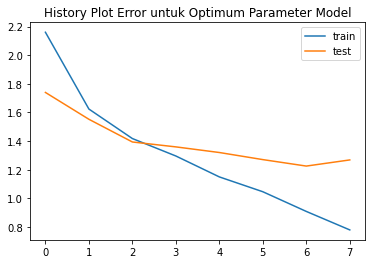

In [44]:
## Plot Training History
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.title('History Plot Error untuk Optimum Parameter Model')
plt.legend()
plt.show()

#### 6.
Gunakan _pre-trained_ model yg telah dibuat tersebut untuk diimplementasikan pada dataset $\text{CIFAR 100}$ untuk kelas $1$ hingga kelas $10$ (masing-masing kelas terdiri dari
$100$ citra) dengan rasio _data train_ dan _data test_ sebanyak $60\% : 40\%$. Kemudian hitung matrik evaluasi ($\text{accuration}$, $\text{sensitivity}$, $\text{specifity}$, dan $f_{1}\text{ score}$) dari _data train_ dan _data test_.

##### Load Data CIFAR 100

In [45]:
x_100, y_100 = load_dataset_cifar100()
x_100.shape

169009152/169001437 [==============================] - 11s 0us/step


(60000, 32, 32, 3)

##### Mengambil Dataset Sebanyak 100 Per Kelasnya

In [68]:
idx_sample_100 = np.array([],dtype=int)

for i in range(10):
    idx = (y == i).reshape(x.shape[0])
    idx_data = np.where(idx == True)
    sampled_list = np.random.choice(idx_data[0], size=100, replace=False)
    idx_sample_100 = np.concatenate((idx_sample_100, sampled_list), axis=0)

##### Melakukan Validasi Apakah Shape-nya Sudah Valid atau Belum

In [69]:
x_sample_100 = x[idx_sample_100]
y_sample_100 = y[idx_sample_100]
x_sample_100.shape, y_sample_100.shape

((1000, 32, 32, 3), (1000, 1))

##### Melakukan Normalisasi untuk $x$

In [70]:
x_sample_100 = normalize(x_sample_100)

##### Merubah Menjadi Matrix Binary untuk $y$

In [71]:
y_sample_100 = tf.keras.utils.to_categorical(y_sample_100)

##### Memecah Menjadi 60 : 40 ~ Train : Test

In [72]:
x_train_100, x_test_100, y_train_100, y_test_100 = train_test_split(x_sample_100, y_sample_100, test_size=0.4)

##### Melakukan Evaluasi Pre-Trained Model dari Train Sebelumnya

In [73]:
pre_trained_model = load_model('checkpoint_model.h5', compile=True, custom_objects={
    "recall": recall,
    "specificity": specificity,
    "f1_score": f1_score
})
compare_train_and_test(pre_trained_model, x_train_100, y_train_100, x_test_100, y_test_100)

,Accuracy,Sensitivity,Specificity,F1 Score
Data Train,0.548333,0.479167,0.973928,0.558774
Data Test,0.565000,0.468750,0.972222,0.543944


#### 7.
Buat arsitektur $\text{Convolutional Neural Network}$ yang baru dengan menggunakan semua _hidden layer pre-trained_ dari model sebelumnya, lakukan _freezing_ pada semua _hidden layer_ tersebut, lalu ganti _layer output_ $\text{softmax}$ dengan layer baru.

In [74]:
## Fungsi untuk melakukan freeze pada layer
def make_freeze(layer):
    layer.trainable = False
    return layer

## Melakukan copy untuk semua layer
copy_layers = [make_freeze(layer) for layer in pre_trained_model.layers]

## Me-replace ouput layer dengan layer baru dan trainable
copy_layers[-1] = Dense(10, activation=tf.nn.softmax)

## Membangun Model
new_cnn_model = create_model(0.0025, copy_layers)

#### 8.
Implementasikan model poin $(7)$ pada dataset $\text{CIFAR 100}$ untuk kelas $1$ hingga kelas $10$ dengan rasio _data train_ dan _data test_ sebanyak $60\% : 40\%$. Kemudian hitung matrik evaluasi ($\text{accuration}$, $\text{sensitivity}$, $\text{specificity}$, dan $f_{1}\text{ score}$) dari _data train_ dan _data test_.

##### Melakukan Train pada Model CNN Baru

In [75]:
## Mendefinisikan Early Stopping untuk Semua Model CNN Checkpoint dan Seterusnya
new_es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)

In [76]:
checkpoint = ModelCheckpoint("checkpoint_new_cnn_model.h5", monitor='loss', verbose=0, mode='auto', save_freq=1)

## Menurunkan jumlah batch seiring dengan berkurangnya jumlah data train
new_cnn_model_history = new_cnn_model.fit(x_train_100, y_train_100, epochs=100, batch_size=25, validation_data=(x_test_100, y_test_100), use_multiprocessing=True, callbacks=[new_es, checkpoint], verbose=1)

Epoch 1/100
24/24 [==============================] - 1s 48ms/step - loss: 3.0415 - accuracy: 0.1300 - recall: 0.0417 - specificity: 0.9819 - f1_score: 0.0667 - val_loss: 2.5262 - val_accuracy: 0.1350 - val_recall: 0.0325 - val_specificity: 0.9950 - val_f1_score: 0.0578
Epoch 2/100
24/24 [==============================] - 1s 39ms/step - loss: 2.2138 - accuracy: 0.2467 - recall: 0.0417 - specificity: 0.9952 - f1_score: 0.0747 - val_loss: 1.9931 - val_accuracy: 0.2850 - val_recall: 0.0750 - val_specificity: 0.9967 - val_f1_score: 0.1331
Epoch 3/100
24/24 [==============================] - 1s 42ms/step - loss: 1.8139 - accuracy: 0.3450 - recall: 0.1117 - specificity: 0.9933 - f1_score: 0.1878 - val_loss: 1.7409 - val_accuracy: 0.3725 - val_recall: 0.1150 - val_specificity: 0.9939 - val_f1_score: 0.1949
Epoch 4/100
24/24 [==============================] - 1s 41ms/step - loss: 1.6048 - accuracy: 0.4367 - recall: 0.1700 - specificity: 0.9931 - f1_score: 0.2682 - val_loss: 1.5856 - val_accurac

##### Menghitung Matrik Evaluasi Model CNN Baru

In [77]:
compare_train_and_test(new_cnn_model, x_train_100, y_train_100, x_test_100, y_test_100)

,Accuracy,Sensitivity,Specificity,F1 Score
Data Train,0.626667,0.422697,0.987756,0.549617
Data Test,0.560000,0.375000,0.982372,0.487980


##### Melakukan _Plotting Error_

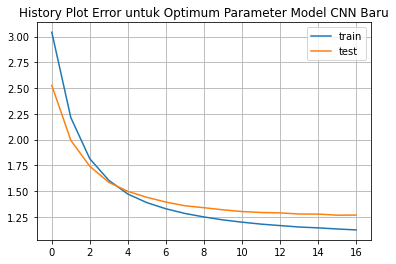

In [78]:
## Plot Training History
plt.plot(new_cnn_model_history.history['loss'], label='train')
plt.plot(new_cnn_model_history.history['val_loss'], label='test')
plt.title('History Plot Error untuk Optimum Parameter Model CNN Baru')
plt.grid()
plt.legend()
plt.show()

#### 9.
Lalu lakukan _unfreeze_ pada satu _hidden layer_ ($\text{conv-pool-actv}$) paling atas dan lakukan kembali proses training menggunakan deskripsi data yang sama dengan poin $(8)$. Bagaimana hasil yang diperoleh dari perubahan ini?

##### Melakukan _unfreeze_ pada satu _hidden layer_ paling atas

In [79]:
## Disclaimer: Asumsi model-nya sama dengan (8)
## Melakukan unfreeze pada hidden layer paling atas
new_cnn_model.layers[0].trainable = True

##### Melanjutkan Proses Train

In [80]:
checkpoint = ModelCheckpoint("checkpoint_new_cnn_model_phase_2.h5", monitor='loss', verbose=0, mode='auto', save_freq=1)
new_cnn_model_history_phase_2 = new_cnn_model.fit(x_train_100, y_train_100, epochs=100, batch_size=25, validation_data=(x_test_100, y_test_100), use_multiprocessing=True, callbacks=[new_es, checkpoint])

Epoch 1/100
24/24 [==============================] - 1s 41ms/step - loss: 1.1116 - accuracy: 0.6267 - recall: 0.4217 - specificity: 0.9878 - f1_score: 0.5473 - val_loss: 1.2696 - val_accuracy: 0.5650 - val_recall: 0.3675 - val_specificity: 0.9836 - val_f1_score: 0.4826
Epoch 2/100
24/24 [==============================] - 1s 49ms/step - loss: 1.1115 - accuracy: 0.6150 - recall: 0.4183 - specificity: 0.9876 - f1_score: 0.5429 - val_loss: 1.2620 - val_accuracy: 0.5625 - val_recall: 0.3800 - val_specificity: 0.9833 - val_f1_score: 0.4949
Epoch 3/100
24/24 [==============================] - 1s 39ms/step - loss: 1.1094 - accuracy: 0.6150 - recall: 0.4300 - specificity: 0.9878 - f1_score: 0.5550 - val_loss: 1.2718 - val_accuracy: 0.5625 - val_recall: 0.3925 - val_specificity: 0.9817 - val_f1_score: 0.5011
Epoch 00003: early stopping


##### Menghitung Matrik Evaluasi Model CNN Baru Phase 2

In [81]:
compare_train_and_test(new_cnn_model, x_train_100, y_train_100, x_test_100, y_test_100)

,Accuracy,Sensitivity,Specificity,F1 Score
Data Train,0.631667,0.429825,0.987208,0.554567
Data Test,0.562500,0.391827,0.981036,0.499710


##### Melakukan _Plotting Error Phase 2_

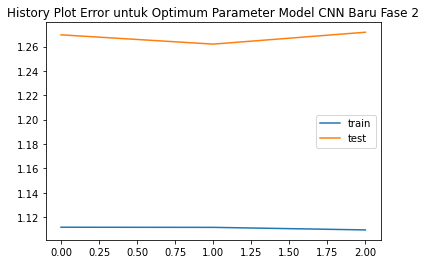

In [82]:
## Plot Training History
plt.plot(new_cnn_model_history_phase_2.history['loss'], label='train')
plt.plot(new_cnn_model_history_phase_2.history['val_loss'], label='test')
plt.title('History Plot Error untuk Optimum Parameter Model CNN Baru Fase 2')
plt.legend()
plt.show()

##### Laporan Hasil

Berdasarkan hasil train yang terakhir, melakukan _unfreeze_ pada layer paling depat tidak memberikan perubahan hasil metrik yang _significant_ dan cenderung sama dengan hasil saat semua layer kecuali _output layer_ di-_freeze_. Hal ini menunjukkan bahwa pembobotan _node_ sudah konvergen bahkan pada saat pertama kali _model_ ini di-_load_ dari _pre-trained_ model yang sudah dijalankan sebelumnya. Bahkan ketika _output layer_-nya di-inisialisasi ulang, hasil pembobotan setelah training menggunakan data $\text{CIFAR 100}$ menghasilkan akurasi yang cenderung sama dengan hasil pembobotan dengan training menggunakan data $\text{CIFAR 10}$.

#### 10.
Tuliskan analisis anda terkait implementasi menggunakan **Transfer Learning**.

- Karena dataset $\text{CIFAR 10}$ dan $\text{CIFAR 100}$ untuk kelas $1 - 10$ cenderung sama, memungkinkan bahwa melatih menggunakan kedua data tersebut dan melakukan uji menggunakan kedua data tersebut akan menghasilkan akurasi yang mirip untuk setiap jenis dataset.
- Karena dataset $\text{CIFAR 10}$ dan $\text{CIFAR 100}$ untuk kelas $1 - 10$ cenderung sama pula, pada saat melakukan _transfer learning_ dari satu dataset ke dataset lainnya, pembobotan akan konvergen di akurasi yang cenderung sama pula. Bahkan apabila kita melakukan inisialisasi ulang pembobotan simpul pada _output layer_, pembobotan simpul pada _output layer_ akan menghasilkan model yang memiliki akurasi sebelum dilakukan pembobotan ulang simpul pada _output layer_.
- Model yang sudah konvergen, apabila _hidden layer_ di-_freeze_ ataupun tidak di-_freeze_ tidak memberikan dampak signifikan dalam memberikan hasil evaluasi. Bahkan model yang sudah konvergen kemudian dilatih kembali menggunakan dataset yang mirip akan konvergen dalam beberapa _epoch_ saja pada saat melakukan _transfer learning_.